# Lista de Exercícios

## Exercício 1 

Usando o construtor de portfolios hedgeados e simulação de Monte Carlo que vocês ou já tem ou vão poder copiar/adaptar de https://github.com/MarcosCarreira/DermanPapers e o paper do Wilmott, simulem o tipo de resultado que ele obteve.

Output desejado:

* Os dois gráficos de P&L no tempo para os casos de hedge com vol real e vol implícita (páginas 24 e 31)
* Distribuição do P&L final e comparação com resultados teóricos (páginas 21 e 29 e paper do Derman)

Podem usar r=q=0 e K=S0  
Para o gráfico 20 trilhas servem  
Para a distribuição umas 500.

-----------------

Importando bibliotecas

In [205]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
%matplotlib inline
plt.style.use('ggplot')

Funções auxiliares

In [206]:
def ca(x,size):
    y=np.empty(size)
    y.fill(x)
    return y

In [207]:
def ppzero(s):
    return pd.Series(pd.Series.append(pd.Series([0]),s).values)

Funções para geração dos caminhos.

In [208]:
def mcpath(nsteps, S0, drift, vol, t):
    
    # generate random numbers
    nmdr=pd.Series(np.random.standard_normal(nsteps))
    
    # find each step
    dt=t*1/nsteps
    ts=pd.Series(ca(dt,nsteps))
    ts0=ppzero(ts)
    s1=(drift-(vol**2)/2)*dt
    s2=vol*np.sqrt(dt)
    steps=s1*pd.Series(ca(1,nsteps))+s2*nmdr
    steps0=ppzero(steps)
    
    # add steps
    cmsteps=steps0.cumsum()
    cts=ts0.cumsum()
    
    # convert steps to path
    Sj=S0*np.exp(cmsteps.values)
    
    # return timeseries [t,St]
    return pd.Series(Sj,index=cts.values)

In [209]:
def mcpaths(npaths, nsteps, S0, drift, vol, t):
    
    # generate npaths using mcpath
    paths=[mcpath(nsteps, S0, drift, vol, t) for j in range(npaths)]
    
    return paths

Cálculo de prêmio e delta (Black'n'Scholes)

In [210]:
def bsv(phi,S,K,r,q,vol_bs, vol_delta,t):
    
    fwd=S*np.exp((r-q)*t)
    efv_bs=t*(vol_bs**2)
    efv_delta=t*(vol_delta**2)
    
    # calculate d1 and d2
    d1_bs=(np.log(fwd/K)+(efv_bs/2))/(np.sqrt(efv_bs))
    d2_bs=(np.log(fwd/K)-(efv_bs/2))/(np.sqrt(efv_bs))
    d1_delta=(np.log(fwd/K)+(efv_delta/2))/(np.sqrt(efv_delta))  
    
    # calculate N(d1) and N(d2)
    Nd1_bs=st.norm.cdf(phi*d1_bs)
    Nd2_bs=st.norm.cdf(phi*d2_bs)
    Nd1_delta=st.norm.cdf(phi*d1_delta)
    
    # calculate premium, delta
    de=phi*np.exp(-q*t)*Nd1_delta
    pr=phi*S*np.exp(-q*t)*Nd1_bs-phi*K*np.exp(-r*t)*Nd2_bs

    return [pr,de]

Evolução do portifolio (opção + delta hedge)

In [211]:
def calcpath(path,phi,K,r,q,vol_bs,vol_delta,T):

    ttm=T-path.index
    bsvpath=np.array([[path.index[j],path.values[j]]+bsv(phi,path.values[j],K,r,q,vol_bs,vol_delta,ttm[j])\
                      for j in range(len(path))])
    return pd.DataFrame(bsvpath,columns=['time','spot','premium','delta'])

In [212]:
def filldf(path,phi,K,r,q,vol_bs,vol_delta,T):

    nstp=len(path)-1
    
    # calculate t,S(t),premium(t),delta(t)
    df=calcpath(path,phi,K,r,q,vol_bs,vol_delta,T)
    
    # cashflows for the option
    df['cfwprem']=0
    df.loc[0,'cfwprem']=-df['premium'][0]
    df.loc[nstp,'cfwprem']=df['premium'][nstp]
    df.loc[nstp,'premium']=0
    
    # calculate time intervals dt
    df['timechg']=df['time'].diff()
    df.loc[0,'timechg']=0
    
    # calculate changes in delta
    df.loc[nstp,'delta']=0
    df['dltchg']=df['delta'].diff()
    df.loc[0,'dltchg']=0
    
    # calculate changes in spot price
    df['spotchg']=df['spot'].diff()
    df.loc[0,'spotchg']=0
    
    # cashflows for the asset
    df['cfwspot']=0
    df.loc[0,'cfwspot']=df['delta'][0]*df['spot'][0]
    df.loc[1:,'cfwspot']=df['dltchg'][1:]*df['spot'][1:]
    
    # dividend cashflows
    df['cfwdivid']=0
    df.loc[1:,'cfwdivid']=-((df['delta'][0:nstp]*df['spot'][0:nstp]).values)*(np.exp(q*df['timechg'][1:].values)-1)
    
    # cashflows before interest
    df['cfwprer']=df['cfwprem']+df['cfwspot']+df['cfwdivid']
    
    # interest and consolidation of cashflows
    df['balance']=0
    df.loc[0,'balance']=df['cfwprer'][0]
    for j in range(1,nstp+1):
        df.loc[j,'balance']=df['balance'][j-1]*(np.exp(r*df['timechg'][j]))+df['cfwprer'][j]
    
    # portfolio
    df['portf']=df['premium']-df['delta']*df['spot']+df['balance']
    
    # consolidated discount factor
    #print(df)
    return df

In [213]:
def portfolio(path,phi,K,r,q,vol_bs,vol_delta,T):
    fulldf=filldf(path,phi,K,r,q,vol_bs,vol_delta,T)
    return pd.Series(fulldf['portf'].values)

In [214]:
def finalpl(path,phi,K,r,q,vol_bs,vol_delta,T):
    portf=portfolio(path,phi,K,r,q,vol_bs,vol_delta,T)
    return portf[len(path)-1]

In [215]:
def finalplpaths(paths,phi,K,r,q,vol_bs,vol_delta,T):
    pls=np.array([finalpl(path,phi,K,r,q,vol_bs,vol_delta,T) for path in paths])
    return pd.Series(pls)

Definindo os parâmetros de entrada

In [221]:
S0=100
phi=1
K=100
r=0
q=0
vol_impl=0.20
vol_real=0.30
T=1
nst1=252
npth=500
MAX_PL=20

Gerando os caminhos aleatórios

In [222]:
allpaths=mcpaths(npth,nst1,S0,r-q,vol_real,T)

Gráfico do P&L para 20 trilhas hedgeando com a volatilidade **implícita**.

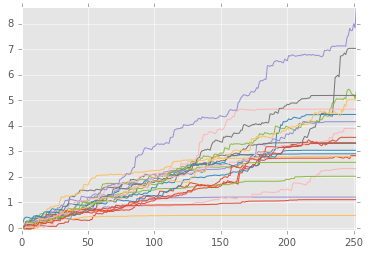

In [223]:
for i, path in enumerate(allpaths): 
    plt.plot(portfolio(path,phi,K,r,q,vol_impl,vol_impl,T))
    if i > MAX_PL:
        break
plt.autoscale(True, 'both', True)
plt.show()

Gráfico do P&L para 20 trilhas hedgeando com a volatilidade **realizada**.

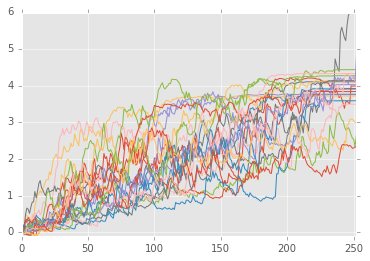

In [224]:
for i, path in enumerate(allpaths):
    plt.plot(portfolio(path,phi,K,r,q,vol_impl,vol_real,T))
    if i > MAX_PL:
        break
plt.autoscale(True, 'both', True)
plt.show()

Distribuição dos P&L's para 500 trilhas com a volatilidade **implícita**.

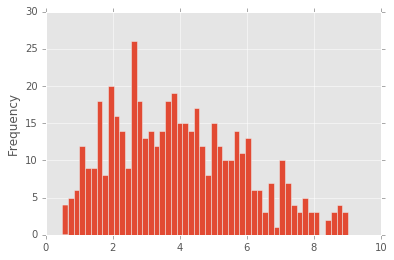

In [225]:
pl_vol_impl=finalplpaths(allpaths,phi,K,r,q,vol_impl,vol_impl,T)
pl_vol_impl.plot(kind='hist', bins=50)

Distribuição dos P&L's para 500 trilhas com a volatilidade **realizada**.

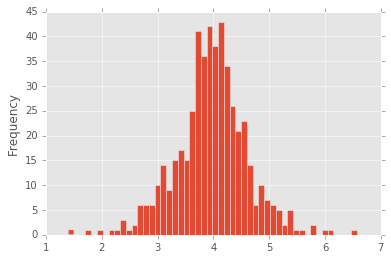

In [226]:
pl_vol_impl=finalplpaths(allpaths,phi,K,r,q,vol_impl,vol_real,T)
pl_vol_impl.plot(kind='hist', bins=50)

--------------------------------------

## Exercício 2

Transformem o P&L final do portfolio em uma função e calculem a breakeven vol das 500 trilhas anteriores para o strike K=S0. Qual a distribuição? Gerem um scatter plot das breakeven vols vs as vols realizadas das trilhas.

--------------

In [227]:
def breakevenvol(path,phi,K,r,q,vol_bs,T,bevol,tol,maxit):
    
    vol=bevol
    volmin=bevol
    erro=finalpl(path,phi,K,r,q,vol_bs,vol,T)
    dvol=0.00001
    i=0 
    
    # Newton
    while ((abs(erro)>tol) and (i<maxit)):
        plportder=(finalpl(path,phi,K,r,q,vol_bs,(vol+dvol),T)-finalpl(path,phi,K,r,q,vol_bs,(vol-dvol),T))/(2*dvol)   
        if (round(plportder,2)==0):
            newvol=bevol*np.random.randint(1, 10)/10
        else:
            newvol=bevol-(erro/plportder)
        if newvol<0:
            newvol=-newvol
        plport=finalpl(path,phi,K,r,q,vol_bs,newvol,T)
        if plport<erro:
            volmin=newvol
        erro=plport
        bevol=newvol
        i=i+1
            
        #print("%.2f | %.2f | %.2f" % (erro,plportder,bevol))
        #print("vol = %.2f | PL = %.2f" % (bevol,erro))

    if i>=maxit:
        bevol=volmin
        
    return bevol

In [228]:
def breakevenvols(paths,phi,K,r,q,vol_bs,T,bevol,tol,maxit):
    
    vols=list()  
    for path in paths:
        vols.append(breakevenvol(path,phi,K,r,q,vol_bs,T,bevol,tol,maxit))
    return vols  

In [229]:
vol_be=0.3
tol=0.1
maxit=30

In [230]:
vols=breakevenvols(allpaths,phi,K,r,q,vol_impl,T,vol_be,tol,maxit)

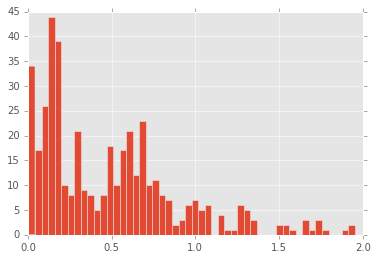

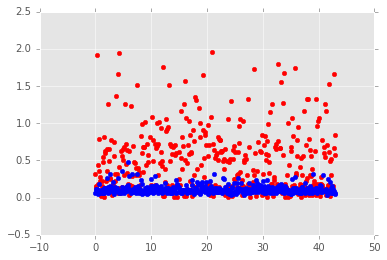

In [236]:
volt=list()
stds=list()
for j, path in enumerate(allpaths):
    if (vols[j]!=-1) and (vols[j]<2):
        volt.append(vols[j])
        stds.append(np.std(path)/100)

plt.hist(volt,bins=50)
plt.show()

x=list(1*j/10 for j in range(len(volt)))
plt.scatter(x,volt,color='red')
plt.scatter(x,stds,color='blue')
plt.show()

---------------------------

## Exercício 3

Usem as primeiras 20 trilhas e gerem o breakeven smile para cada uma dessas trajetórias (usem 5 strikes para cada smile, -10 delta, -25 delta, ATM, 25 delta, 10 delta). Algo a observar?

-----------------

Delta (Black'n'Scholes)

In [237]:
def deltaBS(phi,S,K,r,q,vol,t):
    
    fwd=S*np.exp((r-q)*t)    
    efv=t*(vol**2)
      
    d1=(np.log(fwd/K)+(efv/2))/(np.sqrt(efv))  
    Nd1=st.norm.cdf(phi*d1)
    
    de=phi*np.exp(-q*t)*Nd1

    return de

Encontra K a partir do delta.

In [238]:
def findK(deltaTgt,phi,S,K,r,q,vol,t,tol,maxit):
    
    delta=deltaBS(phi,S,K,r,q,vol,t)
    erro=abs(delta-deltaTgt)
    dK=0.00001
    i=0 
    Kmin=K

    # Newton
    while ((abs(erro)>tol) and (i<maxit)):
        deltaDer=(deltaBS(phi,S,(K+dK),r,q,vol,t)-deltaBS(phi,S,(K-dK),r,q,vol,t))/(2*dK)   
        newK=K-(erro/deltaDer)
        delta=deltaBS(phi,S,newK,r,q,vol,t)
        if (delta-deltaTgt)<erro:
            Kmin=newK
        erro=delta-deltaTgt
        K=newK
        i=i+1

    if i>=maxit:
        K=Kmin
        
    return K

Definindo os parâmetros:

In [239]:
tol=0.1
maxit=30
maxpath=20
deltaTgt=[0.1, 0.25, 0.5, 0.75, 0.9]

Construindo os vetores de strike e vol:

In [240]:
strikesPath=list()
volsPath=list()

for i in range(maxpath):
    
    strikes=list()
    vols=list()
    
    for j in range(len(deltaTgt)):
        strikes.append(findK(deltaTgt[j],phi,S0,K,r,q,vol_impl,T,tol,maxit))
        vols.append(breakevenvol(allpaths[i],phi,strikes[j],r,q,vol_impl,T,vol_real,tol,maxit))
    
    strikesPath.append(strikes)
    volsPath.append(vols)

Construindo os gráficos:

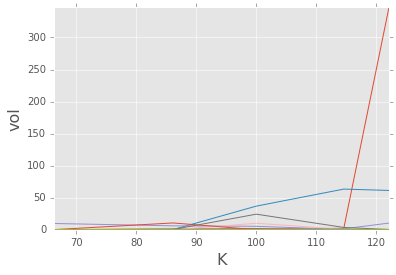

In [241]:
for i in range(len(strikesPath)):
    plt.plot(strikesPath[i],volsPath[i])
    plt.xlabel('K', fontsize=16)
    plt.ylabel('vol', fontsize=16)

plt.autoscale(True, 'both', True)
plt.show()

---------------------

## Exercício 4

Usem as primeiras 5 trilhas e para cada trilha gerem o gráfico com o P&L final do portfolio para cada strike em função da vol usada no hedge (usem 5 strikes para cada smile, -10 delta, -25 delta, ATM, 25 delta, 10 delta). Algo a observar?

----------------

Calcula o P&L para cada um dos strikes em cada uma das trilhas:

In [242]:
maxpath=5
portPathImpl=list()
portPathBE=list()
vols=list()
for i in range(maxpath):
    portImpl=list()
    portBE=list()
    vols.append(breakevenvol(allpaths[i],phi,K,r,q,vol_impl,T,vol_real,tol,maxit))
    for j in range(len(strikesPath[i])):
        portImpl.append(portfolio(allpaths[i],phi,strikesPath[i][j],r,q,vol_impl,vol_impl,T))
        portBE.append(portfolio(allpaths[i],phi,strikesPath[i][j],r,q,vol_impl,vols[i],T))
    portPathImpl.append(portImpl)
    portPathBE.append(portBE)
    

Exibe os gráficos:

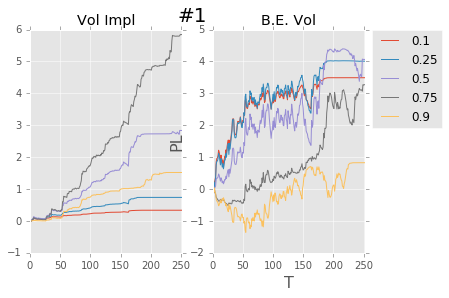

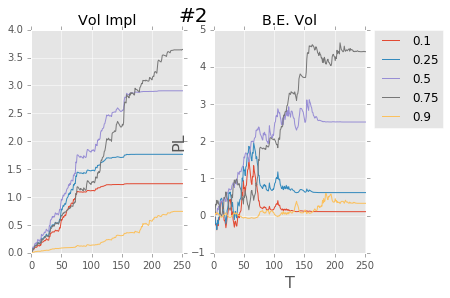

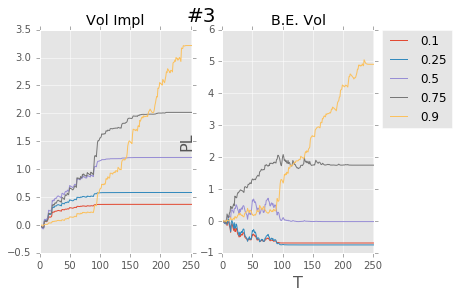

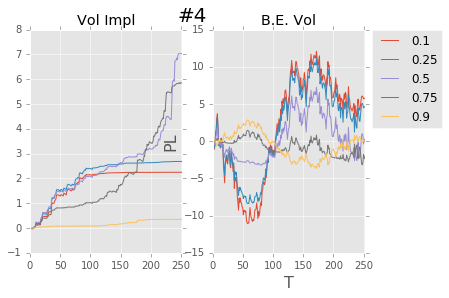

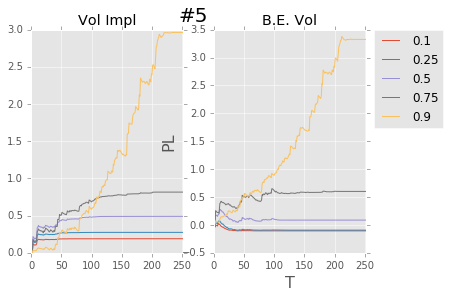

In [244]:
for i in range(len(portPathImpl)):
    line=list()
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
    
    for j in range(len(portPathImpl[i])):
        ax1.plot(portPathImpl[i][j], label=str(deltaTgt[j]))
        ax1.set_title("Vol Impl")
        ax2.plot(portPathBE[i][j], label=str(deltaTgt[j]))
        ax2.set_title("B.E. Vol")
        
    plt.suptitle('#%d' % (i+1), fontsize=20)
    plt.xlabel('T', fontsize=16)
    plt.ylabel('PL', fontsize=16)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.autoscale(True, 'x', True)
    plt.show()

--------------

## Exercício 5

Usando dados reais (2 períodos de 6 meses, um calmo e outro de crise), calcule breakeven smiles de 3 e 6 meses.

------------------

Definindo os inputs e lendo os arquivos de entrada:
  * ex5_calmo.csv - USDBRL entre 15/5 e 14/11/2012
  * ex5_crise.csv - USDBRL entre 15/5 e 13/11/2015

In [245]:
phi=1
vol_impl=0.20
vol_real=0.30
T=1
nst1=252
npth=500
MAX_PL=10

In [246]:
import csv

with open('ex5_calmo.csv', 'rt') as csvfile:
    reader = list(csv.reader(csvfile, delimiter=';'))
    path=list()
    times=list()
    for i,row in enumerate(reader):
        times.append(i/len(reader))
        path.append(float(row[5].replace(",",".")))
    pathCalmo = pd.Series(path,times)

with open('ex5_crise.csv', 'rt') as csvfile:
    reader = list(csv.reader(csvfile, delimiter=';'))
    path=list()
    times=list()
    for i,row in enumerate(reader):
        times.append(i/len(reader))
        path.append(float(row[5].replace(",",".")))  
    pathCrise = pd.Series(path,times)

Calcula os strikes e as break-even vols.

In [249]:
strikesCalmo=list()
strikesCrise=list()
volsCalmo=list()
volsCalmoHalf=list()
volsCrise=list()
volsCriseHalf=list()

S0Calmo=pathCalmo[0]
KCalmo=S0Calmo
S0Crise=pathCrise[0]
KCrise=S0Crise

for i in range(len(deltaTgt)):
    strikesCalmo.append(findK(deltaTgt[i],phi,S0Calmo,KCalmo,r,q,vol_impl,T,tol,maxit))
    strikesCrise.append(findK(deltaTgt[i],phi,S0Crise,KCrise,r,q,vol_impl,T,tol,maxit))
    
for i in range(len(strikesCalmo)):
    volsCalmo.append(breakevenvol(pathCalmo,phi,strikesCalmo[i],r,q,vol_impl,T,vol_real,tol,maxit))

pathCalmoHalf=pathCalmo.copy()
pathCalmoHalf.iloc[:int(round(len(pathCalmo)/2))]
for i in range(len(strikesCalmo)):
    volsCalmoHalf.append(breakevenvol(pathCalmoHalf,phi,strikesCalmo[i],r,q,vol_impl,T,vol_real,tol,maxit))
    
for i in range(len(strikesCrise)):
    volsCrise.append(breakevenvol(pathCrise,phi,strikesCrise[i],r,q,vol_impl,T,vol_real,tol,maxit))

pathCriseHalf=pathCrise.copy()
pathCriseHalf.iloc[:int(round(len(pathCrise)/2))]
for i in range(len(strikesCrise)):
    volsCriseHalf.append(breakevenvol(pathCriseHalf,phi,strikesCrise[i],r,q,vol_impl,T,vol_real,tol,maxit))

Plotando os gráficos.

[2.4367299568111265, 2.2859789403857915, 1.9946999999999999, 1.7181534531654685, 1.3229164344819626]
[3.6518576892939052, 3.4259314404932919, 2.9893999999999998, 2.5749475775393829, 1.9826171300451527]
[0.3, 0.3, 4.4252707870012102, 0.3, 0.3]
[0.049085944905679357, 0.3, 0.3, 0.3, 0.3]


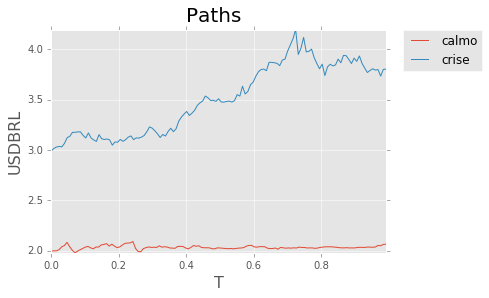

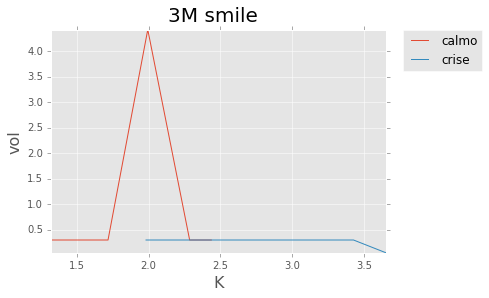

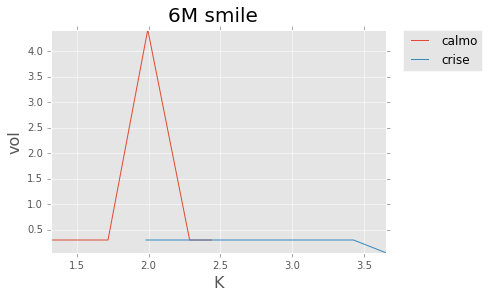

In [252]:
print(strikesCalmo)
print(strikesCrise)
print(volsCalmo)
print(volsCrise)

# Comparação visual entre os paths
plt.plot(pathCalmo, label="calmo")
plt.plot(pathCrise, label="crise")
plt.suptitle("Paths", fontsize=20)
plt.xlabel('T', fontsize=16)
plt.ylabel('USDBRL', fontsize=16)
plt.autoscale(True, 'both', True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# smiles para o período de 3M
plt.plot(strikesCalmo,volsCalmoHalf,label="calmo")
plt.plot(strikesCrise,volsCriseHalf,label="crise")
plt.suptitle("3M smile", fontsize=20)
plt.xlabel('K', fontsize=16)
plt.ylabel('vol', fontsize=16)
plt.autoscale(True, 'both', True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# smile para o período de 6M
plt.plot(strikesCalmo,volsCalmo,label="calmo")
plt.plot(strikesCrise,volsCrise,label="crise")
plt.suptitle("6M smile", fontsize=20)
plt.xlabel('K', fontsize=16)
plt.ylabel('vol', fontsize=16)
plt.autoscale(True, 'both', True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()